In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.cm import get_cmap
import seaborn as sns
from gekko import GEKKO
from lib import *

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem

Suppose we have state variable $x \in \mathbb{R}$ and **binary** control variable $i$ (i.e. it's just a switch with modes "off" = 0 and "on" = 1). Both depend on time $t$. We need to find such a solution

$$ 
F(\textbf{x}, \textbf{i}) \rightarrow
\min\limits_{\textbf{x}, \textbf{i}}
, \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(t) = f(x(t), i(t)) \\
\end{array} \right.
$$

where
* variables' paths
    * $\textbf{x} = [x(0), x(1), \dots, x(T)]$ - values of the state variable $x$ at time $t$
    * $\textbf{i} = [i(0), i(1), \dots, i(T-1)]$ - values of the **binary** control variable $i$ at time $t$

* objective function $F(\textbf{x}, \textbf{i}) = \frac{1}{2}\sum\limits^{T}_{t=0} (x(t) - x_{ref})^2$
* equality function $f(x, i) = x - i$
* parameters $T = 20, \ x_0 = 0.8, \ x_{ref} = 0.7$

Set the hyperparameters

In [3]:
# Time horizon:
T = 20
time_step = 0.05
time = np.arange(T + 1) * time_step

# Initial and reference state
x_0 = 0.8
x_ref = 0.7

Define the functions

In [4]:
# Differential equation:
def f(x, i):
    return x - i

# Objective function:
def F(x, i):
    return 0.5 * ((x - x_ref) ** 2)

### 1. Solve the problem with GEKKO

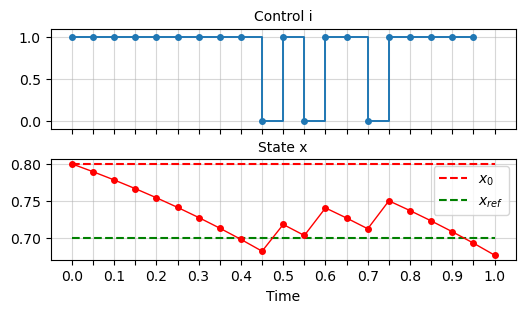

Objective value = 0.016295


In [5]:
history = optimal_control_minimization(x_0, x_ref, time, f, F, integer=True)
show(history)

### 2. Solve the corresponding relaxed problem (continuous) with GEKKO

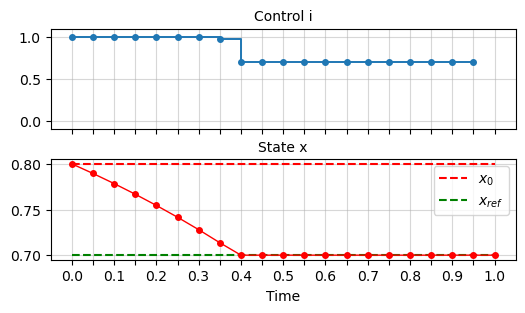

Objective value = 0.012129


In [6]:
history = optimal_control_minimization(x_0, x_ref, time, f, F, integer=False)
show(history)

### 3. Try to substitute a particular solution 

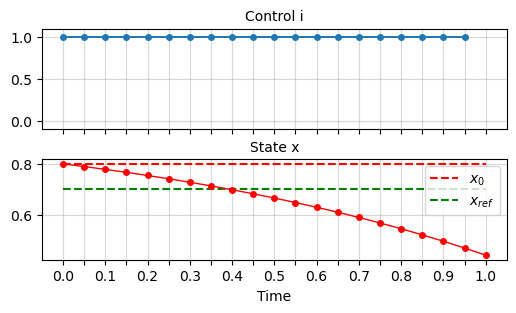

Objective value = 0.143637


In [7]:
const_i = [1] * (T + 1)
history = optimal_control_substituting(x_0, x_ref, time, f, F, const_i=const_i)
show(history)

### 4. Proposed method

Let's consider the binary vector $\textbf{i}$ as a random vector of independent random variables, where each variable $i(t)$ is Bernoulli distributed with the parameter $p_t$ (i.e. it takes the value 1 with probability $p_t$ and the value 0 with probability $1 - p_t$). To simplify further calculations a little let's write $i_t$ instead of $i(t)$

$$
\textbf{i} = 
[i_0, i_1, \dots, i_{T-1}] \sim q(\textbf{i}) = 
% q_0(i_0) \ q_1(i_1) \dots q_{N-1}(i_{N-1}) =
\prod\limits_{t=0}^{T-1} q_t(i_t), 
\quad
q_t(i) = \textbf{Bernoulli}\ (i \mid p_t)
$$


1. Sample $K$ vectors $\textbf{i}_1, \dots, \textbf{i}_K$ from $q(\textbf{i})$.
2. Compute the corresponding state trajectories $\textbf{x}_1, \dots, \textbf{x}_K$.
3. Compute the corresponding objective values $F_1, \dots, F_K = F(\textbf{x}_1, \textbf{i}_1), \dots, F(\textbf{x}_K, \textbf{i}_K)$.
4. Find $S$ best (minimal) values $F_{j_1}, \dots, F_{j_S}$ and corresponding control vectors $\textbf{i}_{j_1}, \dots, \textbf{i}_{j_S}$.
5. Update the distribution $q(\textbf{i})$ as follows:
$$
q^{new}(\textbf{i}) = 
\prod\limits_{t=0}^{T-1} q^{new}_t(i_t), 
\quad
q^{new}_t(i) = \textbf{Bernoulli}\ (i \mid p^{new}_t), 
\quad 
p^{new}_t = \frac{1}{S} \sum\limits_{s=1}^{S} \textbf{i}_{j_s}(t) - 
\text{the $t$-th component of} \ \textbf{i}_{j_s}
$$
Simply put, we update the probability of success $p_t$ according to the number of ones on the $t$-th position in the best solutions $\textbf{i}_{j_1}, \dots, \textbf{i}_{j_S}$.

6. Starting from $p_1 = \dots = p_{T-1} = 0.5$ we take $N$ steps of 1-5.

In [8]:
def sample(n_samples, probabilities):
    """
    Sample K binary vectors from q(p_1, ..., p_{T-1})
    params: 
        n_samples = K - number of samples
        probabilities - parameters p_1 ... p_{T-1}
    returns:
        I - samples
    """
    T = len(probabilities)
    I = np.random.rand(n_samples, T)
    I = (I <= probabilities).astype(np.int32)
    return I

In [9]:
def optimal_control_custom(x_0, x_ref, time, f, F, n_samples, top_s, n_steps):
    """
    params:
        x_0 - initial state
        x_ref - final reference state  
        time - time horizon
        f - differential equation
        F - objective function
        n_samples = K - number of samples
        top_s = S - number of the best solutions
        n_steps = N - number of steps
    returns:
        history: a dict with
            x - predicted state trjectory of x(t)
            i - given sequense of controls i(t)
            obj_val - corresponding objective value F(x, i)
        and some other items
    """
    p = np.ones_like(time) * 0.5
    history = {'p_trace' : [p], 'obj_val_trace': []}
    
    # main iteration loop : 6
    for step in range(1, n_steps+1):
        X = []
        Obj = []
        
        # sample and substitute solutions : 1-3
        I = sample(n_samples, p)
        for const_i in I:
            history_i = optimal_control_substituting(x_0, x_ref, time, f, F, const_i)
            X.append(history_i['x'])
            Obj.append(history_i['obj_val'])
        
        # find best solutions : 4
        top_S_id = np.argsort(Obj)[:top_s]
        
        print('-'*100)
        print(f'Step {step}/{n_steps} | Objective value {np.min(Obj):.5f}')
        w = [1.0 if k in top_S_id else 0.0 for k in range(n_samples)]
        show_X(X, x_0, x_ref, time, w, p)

        # update probabilities : 5
        p = I[top_S_id].mean(0)

        history['obj_val_trace'].append(Obj)
        history['p_trace'].append(p)

    best_id = np.argmin(Obj)
    history['time'] = time
    history['x'] = X[best_id]
    history['i'] = I[best_id]
    history['obj_val'] = Obj[best_id]
    history['x_0'] = x_0
    history['x_ref'] = x_ref
    history['obj_val_trace'] = np.array(history['obj_val_trace'])
    history['p_trace'] = np.array(history['p_trace'])
    return history

----------------------------------------------------------------------------------------------------
Step 1/5 | Objective value 0.42483


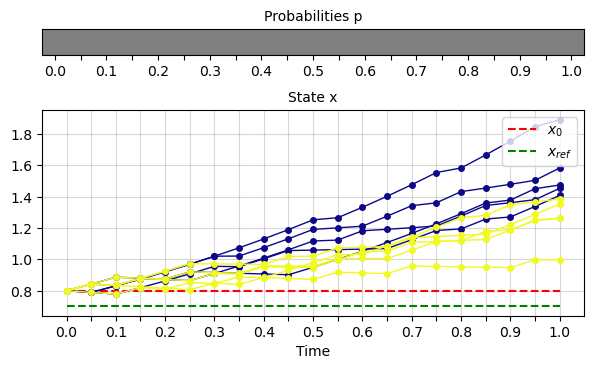

----------------------------------------------------------------------------------------------------
Step 2/5 | Objective value 0.56644


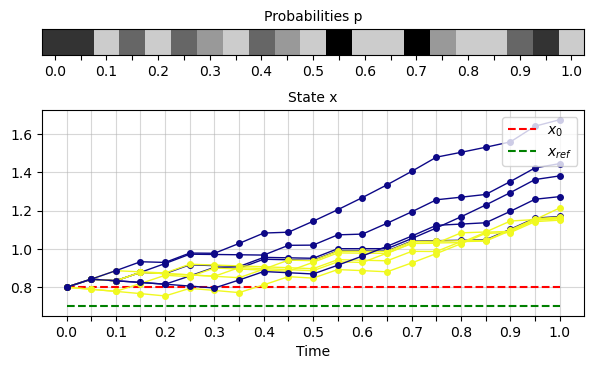

----------------------------------------------------------------------------------------------------
Step 3/5 | Objective value 0.32210


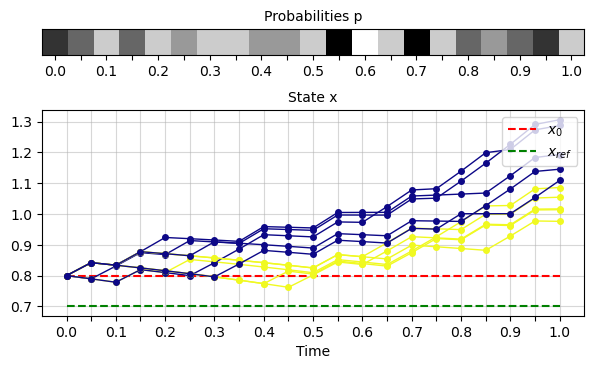

----------------------------------------------------------------------------------------------------
Step 4/5 | Objective value 0.02966


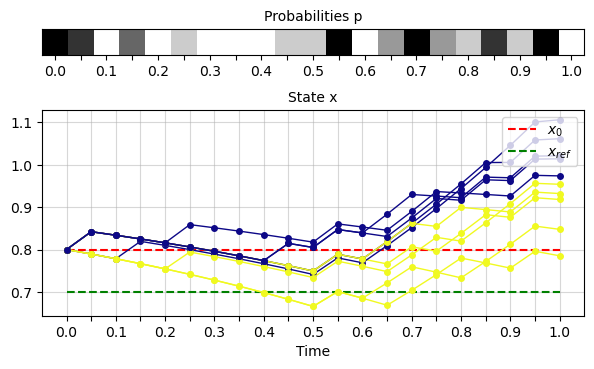

----------------------------------------------------------------------------------------------------
Step 5/5 | Objective value 0.01449


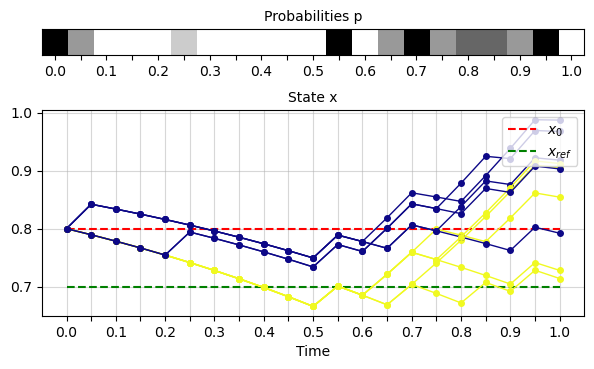

In [31]:
np.random.seed(49)
history = optimal_control_custom(x_0, x_ref, time, f, F, n_samples=10, top_s=5, n_steps=5)

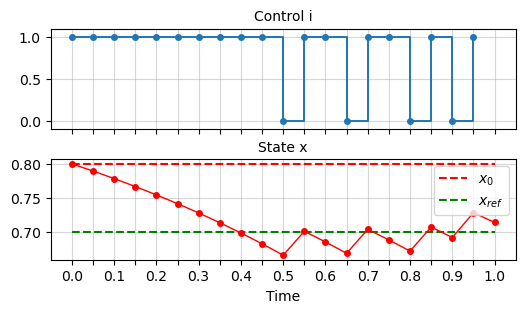

Objective value = 0.014486


In [32]:
show(history)

It's better than the GEKKO solution.

In [33]:
history['p_trace'][-1]

array([0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. ,
       0.4, 0. , 0.6, 0.6, 0.4, 0.4, 0. , 1. ])

As we can see, the final $p_1, \dots, p_{N-1}$ are almost binary. It means that the final $q(\textbf{i})$ is almost a delta-function centered in the optimal solution $\textbf{i}^*$.

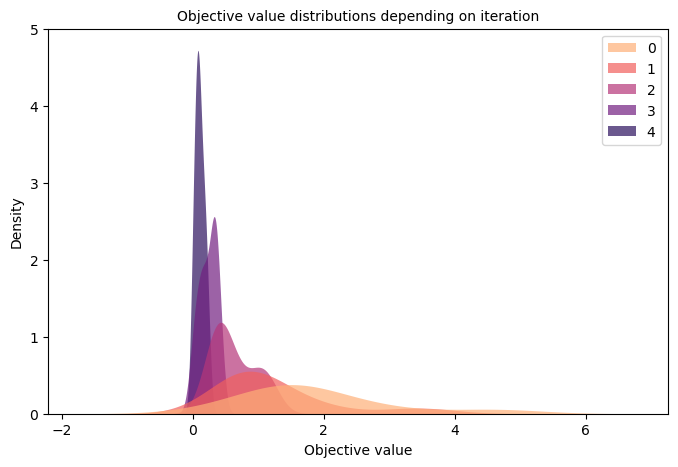

In [34]:
plt.figure(figsize=(8, 5))
plt.title('Objective value distributions depending on iteration', fontsize=10)
sns.kdeplot(
    data=history['obj_val_trace'].T,
    fill=True, common_norm=False, palette="magma_r",
    alpha=0.7, linewidth=0,
)
plt.xlabel('Objective value', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.ylim(0, 5)
plt.show()

As we can see, the distribution of objective value becames almost a delta-function centered in the minimum $F(\textbf{x}^*, \textbf{i}^*)$.

### 5. Proposed method: improvement 1

Заметим одну деталь - в процессе решения мы можем далеко уйти от минимума, который случайно мог быть найден на промежуточном шаге:

In [41]:
np.random.seed(49)
history = optimal_control_custom(x_0, x_ref, time, f, F, n_samples=10, n_steps=7, 
                                 mode='top-s', verbose=1, update=False, lamb=0.5)

--------------------------------------------------------------------------------
Step 1/7 | Objective Value (current) 0.42483 | Objective Value (total) 0.42483
--------------------------------------------------------------------------------
Step 2/7 | Objective Value (current) 0.56644 | Objective Value (total) 0.56644
--------------------------------------------------------------------------------
Step 3/7 | Objective Value (current) 0.32210 | Objective Value (total) 0.32210
--------------------------------------------------------------------------------
Step 4/7 | Objective Value (current) 0.02966 | Objective Value (total) 0.02966
--------------------------------------------------------------------------------
Step 5/7 | Objective Value (current) 0.01449 | Objective Value (total) 0.01449
--------------------------------------------------------------------------------
Step 6/7 | Objective Value (current) 0.01449 | Objective Value (total) 0.01449
----------------------------------------

Чтобы избежать этого, будем запоминать наилучшее решение на каждом шаге и учитывать его на последующих. 

In [42]:
np.random.seed(49)
history = optimal_control_custom(x_0, x_ref, time, f, F, n_samples=10, n_steps=7, 
                                 mode='top-s', verbose=1, update=True, lamb=0.5)

--------------------------------------------------------------------------------
Step 1/7 | Objective Value (current) 0.42483 | Objective Value (total) 0.42483
--------------------------------------------------------------------------------
Step 2/7 | Objective Value (current) 0.56644 | Objective Value (total) 0.42483
--------------------------------------------------------------------------------
Step 3/7 | Objective Value (current) 0.32210 | Objective Value (total) 0.32210
--------------------------------------------------------------------------------
Step 4/7 | Objective Value (current) 0.02966 | Objective Value (total) 0.02966
--------------------------------------------------------------------------------
Step 5/7 | Objective Value (current) 0.01449 | Objective Value (total) 0.01449
--------------------------------------------------------------------------------
Step 6/7 | Objective Value (current) 0.01449 | Objective Value (total) 0.01449
----------------------------------------

### 6. Proposed method: improvement 1

Instead of taking the top-s solutions $\textbf{i}_{j_1}, \dots, \textbf{i}_{j_S}$ let us assign all solutions $\textbf{i}_1, \dots, \textbf{i}_K$ some weights $w_1, \dots, w_K$ according to their target values $F_1, \dots, F_K$, and then take the weighted average of these solutions as the new probabilities $p_1, \dots, p_T$. Then our algorithm will change in items 4 and 5 as follows:

4. Compute the corresponding weights $w_1, \dots, w_K$, where $w_k = f_w(F_k)$
5. Update the distribution $q(\textbf{i})$ as follows:
$$
q^{new}(\textbf{i}) = 
\prod\limits_{t=0}^{T-1} q^{new}_t(i_t), 
\quad
q^{new}_t(i) = \textbf{Bernoulli}\ (i \mid p^{new}_t), 
\quad 
p^{new}_t = \frac{\sum\limits_{k=1}^{K} w_k \textbf{i}_k(t)}{\sum\limits_{k=1}^{K} w_k}
$$
where $\textbf{i}_k(t)$ is the $t$-th component of $\textbf{i}_k$.

Different variants of the function $f_w(F)$:
1. The Indicator function $f_w(F) = [F \in \{F_{j_1}, \dots, F_{j_S}\}]$ - it checks whether a particular value $F$ is one of the best, i.e. it's in the set of top-S best solutions' objective values $F_{j_1}, \dots, F_{j_S}$. In this case, the algorithm is exactly the same as the previous one.
2. PDF for the exponential distribution $f_w(F \mid \lambda) = \left\{ \begin{array}{ll} \lambda e^{-\lambda F}, & F \geqslant 0 \\ 0, & F < 0 \end{array} \right.$

Different exponential function plots:

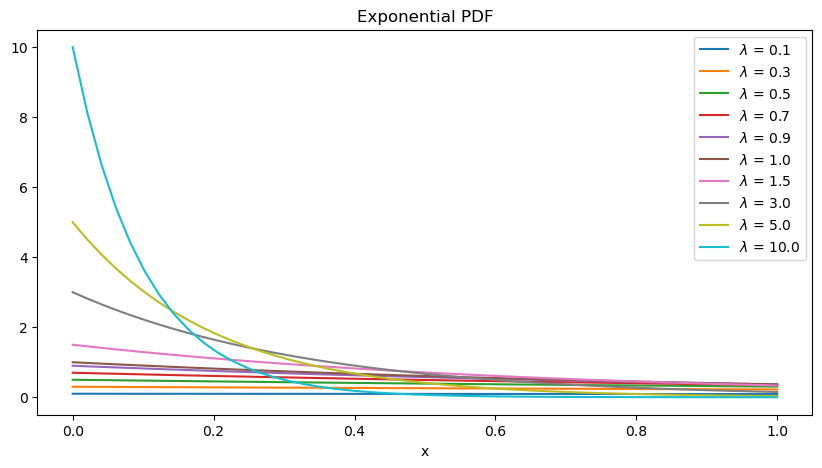

In [486]:
plt.figure(figsize=(10, 5))
plt.title('Exponential PDF')
x = np.linspace(0.0, 1, 50)
lamb_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.5, 3.0, 5.0, 10.0]
for lamb in lamb_list:
    plt.plot(x, exponent(x, lamb=lamb), label=r'$\lambda$ = '+f'{lamb}')
plt.legend()
plt.xlabel('x')
plt.show()

In [541]:
history = optimal_control_custom(x_0, x_ref, time, f, F, n_samples=10, n_steps=5, mode='top-s', verbose=1, lamb=0.5)

--------------------------------------------------------------------------------
Step 0/5 | Objective Value (current) 0.44271 | Objective Value (total) inf
--------------------------------------------------------------------------------
Step 1/5 | Objective Value (current) 0.06911 | Objective Value (total) 0.44271
--------------------------------------------------------------------------------
Step 2/5 | Objective Value (current) 0.01473 | Objective Value (total) 0.06911
--------------------------------------------------------------------------------
Step 3/5 | Objective Value (current) 0.01942 | Objective Value (total) 0.01473
--------------------------------------------------------------------------------
Step 4/5 | Objective Value (current) 0.02354 | Objective Value (total) 0.01473


In [466]:
histories = {}
n_samples = 50
n_steps = 5
experiments = {
    'top-s' : (0.1, 0.3, 0.5, 0.7),
    'expon' : (0.2, 0.5, 0.8, 1.0, 1.5, 3.0, 5.0)
}

for mode, param_list in experiments.items():
    histories[mode] = []
    for lamb in param_list:
        print('-'*34)
        print(f'mode: {mode} | lamb: {lamb}')
        history_exp_lamb = optimal_control_custom(
            x_0, x_ref, time, f, F, n_samples=n_samples, 
            mode=mode, lamb=lamb, n_steps=n_steps, verbose=1
        )
        histories[mode].append({
            'param' : lamb,
            'history' : history_exp_lamb
        })
        print()

----------------------------------
mode: top-s | lamb: 0.1
----------------------------------
Step 0/5 | Objective value 0.04480
----------------------------------
Step 1/5 | Objective value 0.01419
----------------------------------
Step 2/5 | Objective value 0.01660
----------------------------------
Step 3/5 | Objective value 0.01583
----------------------------------
Step 4/5 | Objective value 0.01420

----------------------------------
mode: top-s | lamb: 0.3
----------------------------------
Step 0/5 | Objective value 0.21467
----------------------------------
Step 1/5 | Objective value 0.01536
----------------------------------
Step 2/5 | Objective value 0.01621
----------------------------------
Step 3/5 | Objective value 0.01485
----------------------------------
Step 4/5 | Objective value 0.01420

----------------------------------
mode: top-s | lamb: 0.5
----------------------------------
Step 0/5 | Objective value 0.23456
----------------------------------
Step 1/5 | Objec

In [467]:
def obj_val_dstrb(n_steps, histories, mode):
    for step in range(n_steps):
        plt.figure(figsize=(8, 4))
        plt.title(f'Objective value distributions | mode {mode} | step {step}', fontsize=10)
        for hist in histories[mode]:
            data = hist['history']['obj_val_trace'][step]
            label = r'$\lambda$ = ' + str(hist['param'])
            if data.std() < 1e-8:
                data += np.random.randn(*data.shape) * 0.1
            sns.kdeplot(data=data, fill=True, alpha=0.6, clip=(0.0, None), label=label)
        plt.xlabel('Objective value', fontsize=10)
        plt.ylabel('Density', fontsize=10)
    #     plt.ylim(0, 10)
        plt.legend()
        plt.show()

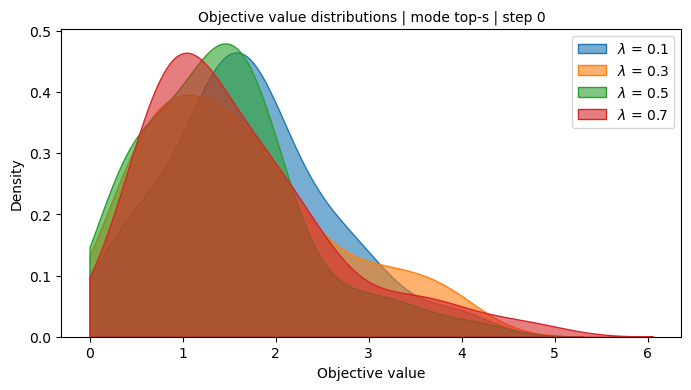

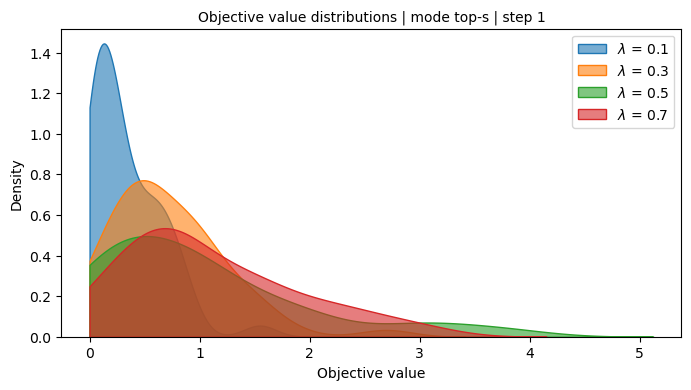

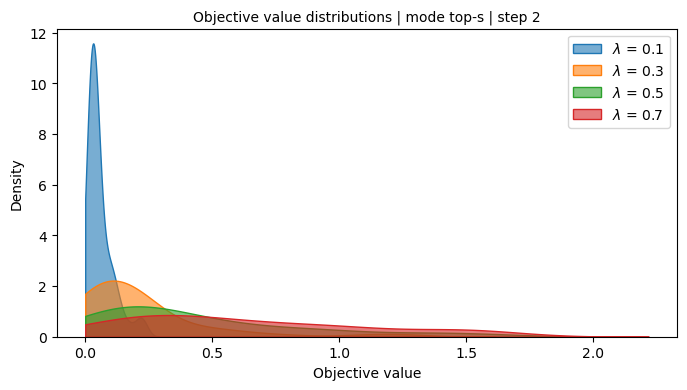

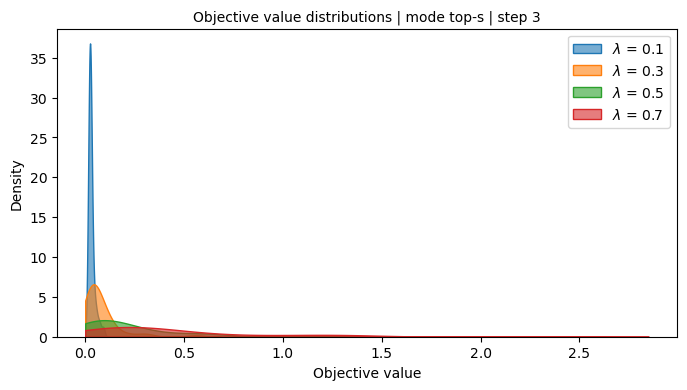

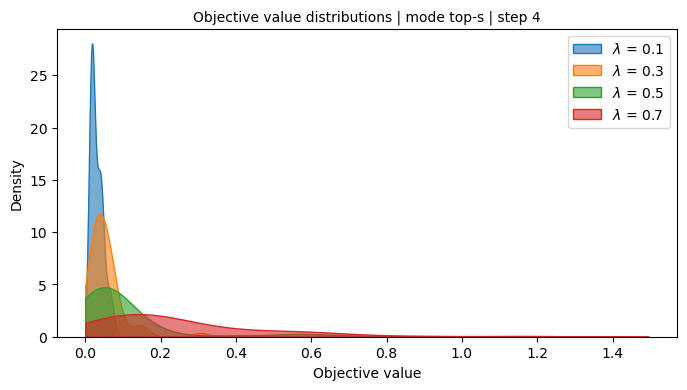

In [468]:
obj_val_dstrb(n_steps, histories, 'top-s')

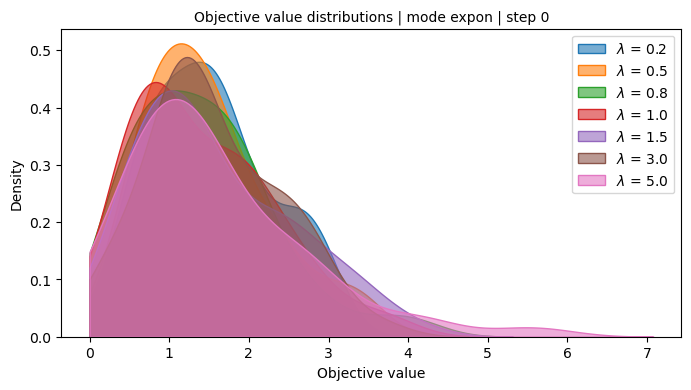

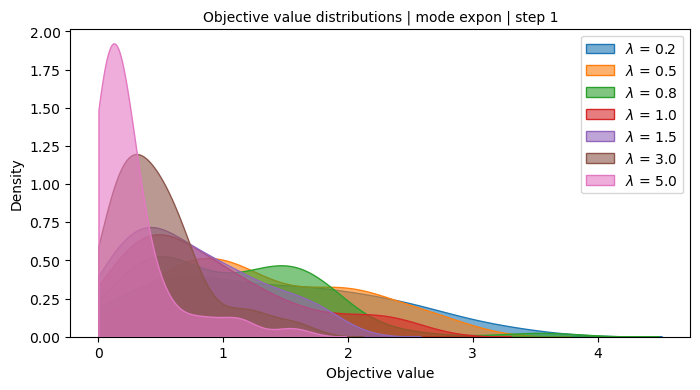

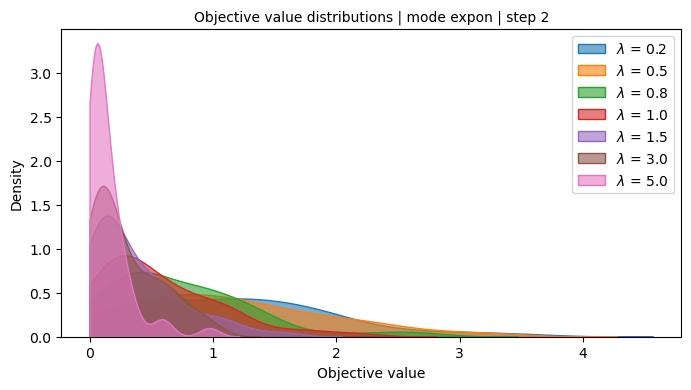

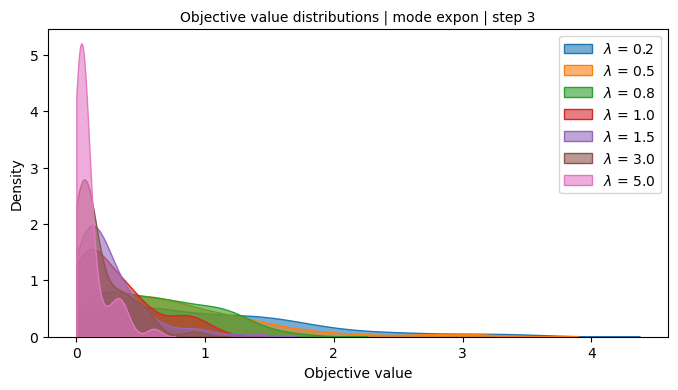

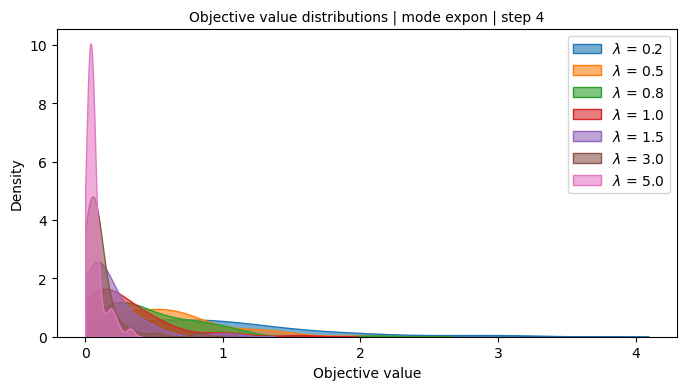

In [469]:
obj_val_dstrb(n_steps, histories, 'expon')

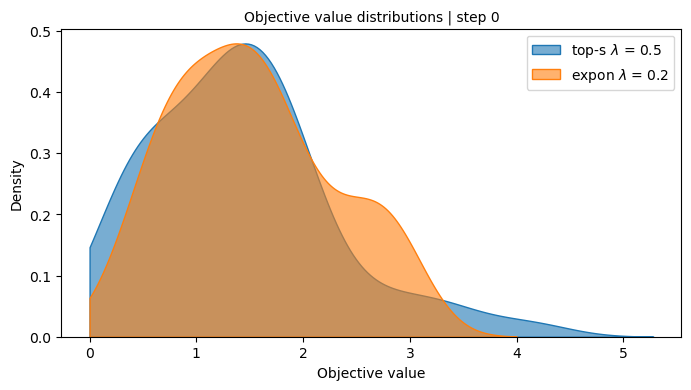

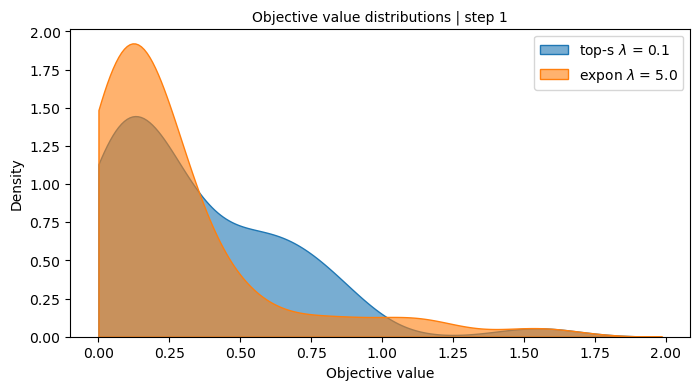

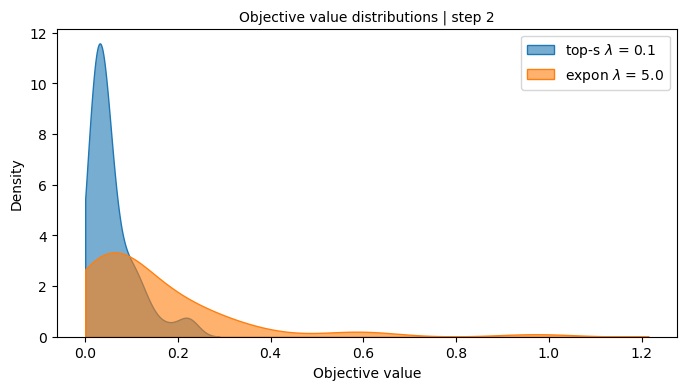

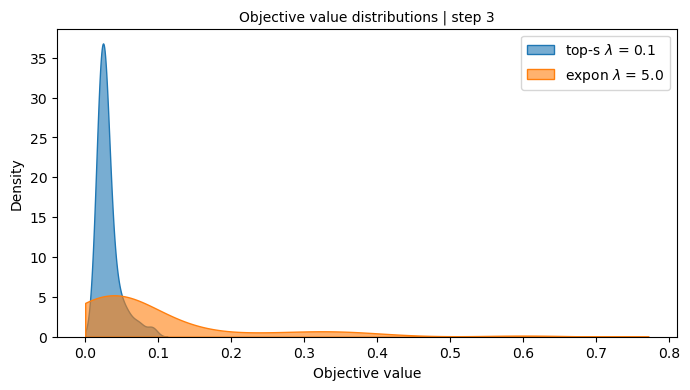

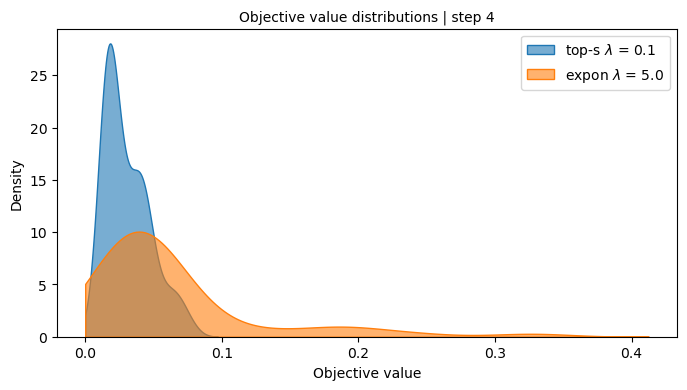

In [509]:
top_histories = {}
for step in range(n_steps):
    plt.figure(figsize=(8, 4))
    plt.title(f'Objective value distributions | step {step}', fontsize=10)
    for mode in histories.keys():
        min_std = lambda h: h['history']['obj_val_trace'][step].std()
        top_hist = min(histories[mode], key=min_std)
        data = top_hist['history']['obj_val_trace'][step]
        label = mode + r' $\lambda$ = ' + str(top_hist['param'])
        if data.std() < 1e-8:
            data += np.random.randn(*data.shape) * 0.1
        sns.kdeplot(data=data, fill=True, alpha=0.6, clip=(0.0, None), label=label)
        plt.xlabel('Objective value', fontsize=10)
        plt.ylabel('Density', fontsize=10)
    #     plt.ylim(0, 10)
    plt.legend()
    plt.show()

### 6. Proposed method: improvement 2

Все, что мы делаем - это пытаемся найти минимум функции $F(\textbf{x}, \textbf{i}) = F(\textbf{x}(\textbf{i}), \textbf{i}) = \hat{F}(\textbf{i})$, достаточно сложной, чтобы не иметь возможности вычислять большое число её значений. Гипотетически, если бы мы знали значения $\hat{F}$ во всех точках $\textbf{i}$, то могли бы задать некоторое истинное распределение $q(\textbf{i})$:
$$
q(\textbf{i}) = \frac{\hat{F}(\textbf{i})}{C}, 
\quad \text{where} \
C = \sum\limits_{\textbf{i}} \hat{F}(\textbf{i}) - 
\text{normilizing constant}
$$
К сожалению, из-за сложности функции $\hat{F}$ мы не можем посчитать нормировочную константу. Возможно, само распределение параметрическое и его можно описать проще, но проверить это невозможно, поэтому мы вынуждены его аппроксимировать.

Учитывая, что вектора $\textbf{i} \in [0, 1]^T$ бинарные, у нас есть только $2^T$ возможных значений функции $\hat{F}(\textbf{i})$. Представим их в виде тензора $\mathbf{F}$ размерности $T$:
$$
\mathbf{F}[\textbf{i}] = 
\mathbf{F}[i_0, i_1, \dots, i_{T-1}] = 
\hat{F}(\textbf{i})
$$

Попробуем аппроксимировать его с помощью ТТ-тензора $\mathcal{F}$ с ядрами $G_0, \dots, G_{T-1}$ вида $\ G_t \in \mathbb{R}^{r_t \times 2 \times r_{t+1}}$:

$$
\mathbf{F}[\textbf{i}] \approx
\mathcal{F}[\textbf{i}] = 
\mathcal{F}[i_0, i_1, \dots, i_{T-1}] = 
\prod\limits_{t=0}^{T-1}G_t[i_t]
$$

### 7. Другие идеи

1. Начальное значение вероятностей
2. Не давать увеличиваться скору
3. Теплый старт 
4. Условное распределение
5. Нужно обходить неподходящие решения
6. Реинфорсмент трик
7. Проверить ограничения
8. Написать теорию